In [259]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [260]:
file_path = '/Users/thomas/Desktop/up_zone_restricted/hall_up_zone_throttled_2024-07-12_14-46-48.csv'

# Import hall data
df1 = pd.read_csv(file_path, names=['x','time'])
df1['time'] = df1['time'].apply(lambda x: int(x))
df1 = df1[['time']]
df1['sensor'] = 'Hall'

# Import omega data
df2 = pd.read_csv(file_path.replace('hall','omega'), names=['x','time'])
df2['time'] = df2['time'].apply(lambda x: int(x))
df2 = df2[['time']]
df2['sensor'] = 'Omega'

# Add time in minutes relative to first tick
first_tick = min(df1.time[0]/1e9/60, df2.time[0]/1e9/60)
df1['time_min'] = df1['time']/1e9/60 - first_tick
df2['time_min'] = df2['time']/1e9/60 - first_tick

# Create the hall dataframes
df_hall = df1 #pd.concat([df1, df3], ignore_index=True)
df_hall = df_hall.sort_values(by='time')
df_hall = df_hall.reset_index(drop=True)
df_hall['hall_frequency'] = 1 / (df_hall['time'].diff().shift(-1)) * 1e9

# Create the omega dataframe
df_omega = df2 #pd.concat([df2, df4], ignore_index=True)
df_omega = df_omega.sort_values(by='time')
df_omega = df_omega.reset_index(drop=True)
df_omega['omega_frequency'] = 1 / (df_omega['time'].diff().shift(-1)) * 1e9

# Merge the hall and omega dataframes
df = pd.concat([df_hall, df_omega], ignore_index=True)
df = df.sort_values(by='time')
df = df.reset_index(drop=True)

# Fill in NaN values
df['hall_frequency'].fillna(method='ffill', inplace=True)
df['omega_frequency'].fillna(method='ffill', inplace=True)

display(df)

/var/folders/c3/d3fq0hlj3j7gpdh35ylfyy1h0000gp/T/ipykernel_6239/670128486.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['hall_frequency'].fillna(method='ffill', inplace=True)
/var/folders/c3/d3fq0hlj3j7gpdh35ylfyy1h0000gp/T/ipykernel_6239/670128486.py:38: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['hall_frequency'].fillna(method='ffill', inplace=True)
/var/folders/c3/d3fq0hlj3j7gpdh35ylfyy1h0000gp/T/ipykernel_6239/670128486

,time,sensor,time_min,hall_frequency,omega_frequency
0,1609460567559685000,Hall,0.000000,24.006722,NaN
1,1609460567601340000,Hall,0.000694,24.009604,NaN
2,1609460567642990000,Hall,0.001388,24.101032,NaN
3,1609460567684482000,Hall,0.002080,24.073182,NaN
4,1609460567726022000,Hall,0.002772,24.355789,NaN
...,...,...,...,...,...
19393,1609461625743777000,Hall,17.636402,10.794124,0.005777
19394,1609461625836420000,Hall,17.637946,10.566580,0.005777
19395,1609461625931058000,Hall,17.639523,10.627783,0.005777
19396,1609461626025151000,Hall,17.641091,10.518897,0.005777


In [261]:
# Crop between the first and last Omega ticks
first_omega_tick = list(df[df.sensor=='Omega'].time)[0]
last_omega_tick = list(df[df.sensor=='Omega'].time)[-1]
df = df[df.time>=first_omega_tick]
df = df[df.time<=last_omega_tick]

# Count the gallons per tick
gallons = len(df[df.sensor=='Omega'])
print(f'Gallons during the section: {round(gallons,1)}')
hall_gallons_per_tick = gallons / len(df[df.sensor=='Hall'])
print(f'Gallons per tick: {round(hall_gallons_per_tick,10)}')
print(f"Average GPM: {round(60*np.mean(df[df.sensor=='Omega'].omega_frequency),2)}")

# Compute the GPM using the gallons per tick
df['hall_GPM'] = df['hall_frequency'] * hall_gallons_per_tick * 60
df['omega_GPM'] = df['omega_frequency'] * 1 * 60

# Filter out errors
df = df[df.omega_GPM<7]
df = df[df.hall_GPM<7]
#df = df[df.omega_frequency>0.01]
#df = df[df.hall_frequency>30]

Gallons during the section: 15
Gallons per tick: 0.0008151288
Average GPM: 0.89


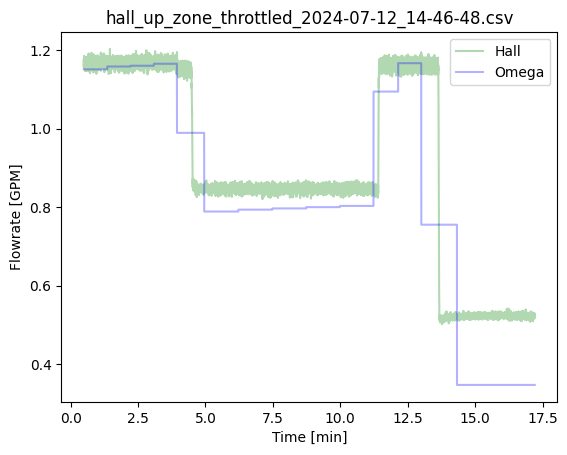

In [262]:
# Plot results
fig, ax = plt.subplots(1,1)
ax.plot(list(df.time_min), list(df.hall_GPM), alpha=0.3, label=f'Hall', color='green')
ax.plot(list(df.time_min), list(df.omega_GPM), alpha=0.3, label=f'Omega', color='blue')
ax.set_ylabel('Flowrate [GPM]')
ax.set_xlabel('Time [min]')
lines1, labels1 = ax.get_legend_handles_labels()
ax.legend()
plt.title(file_path.split('/')[-1])
plt.show()

IndexError: list index out of range

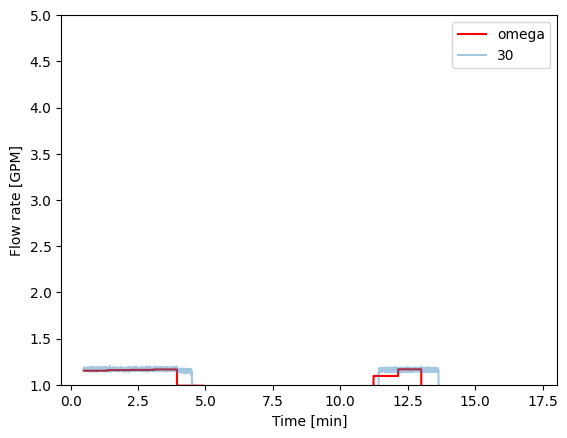

In [263]:
df_backup = df
hall_gpt_list = []
frequency_list = []
PRINT = False

for section in range(6):
    
    # Get the full data back
    df = df_backup

    # Crop the data to the desired section
    if PRINT: print('*'*25 + f'\nDistribution pump: {30+section*5}\n' + '*'*25)
    if section==0: min_time, max_time = 0, 40
    if section==1: min_time, max_time = 50, 85
    if section==2: min_time, max_time = 90, 115
    if section==3: min_time, max_time = 120, 160
    if section==4: min_time, max_time = 170, 210
    if section==5: min_time, max_time = 218, 310

    df = df[df.time_min>=min_time]
    df = df[df.time_min<=max_time]

    # Crop between the first and last Omega ticks
    first_omega_tick = list(df[df.sensor=='Omega'].time)[0]
    last_omega_tick = list(df[df.sensor=='Omega'].time)[-1]
    df = df[df.time>=first_omega_tick]
    df = df[df.time<=last_omega_tick]

    # Count the gallons per tick
    gallons = len(df[df.sensor=='Omega'])
    if PRINT: print(f'Gallons during the section: {round(gallons,1)}')
    hall_gallons_per_tick = gallons / len(df[df.sensor=='Hall'])
    if PRINT: print(f'Gallons per tick: {round(hall_gallons_per_tick,10)}')
    if PRINT: print(f"Average GPM: {round(60*np.mean(df[df.sensor=='Omega'].omega_frequency),2)}")

    # Get average frequency
    if PRINT: print(f"Average hall frequency: {round(np.mean(df[df.sensor=='Hall'].hall_frequency),3)}")
    if PRINT: print(f"Average omega frequency: {round(np.mean(df[df.sensor=='Omega'].omega_frequency),3)}")

    # Save values
    hall_gpt_list.append(hall_gallons_per_tick)
    frequency_list.append(round(np.mean(df[df.sensor=='Hall'].hall_frequency),3))

    # Compute GPM
    df['hall_GPM'] = df['hall_frequency'] * hall_gallons_per_tick * 60
    df['omega_GPM'] = df['omega_frequency'] * 1 * 60
    
    # Plot results
    if section==0:
        plt.plot(list(df.time_min), list(df.omega_GPM), alpha=1, color='red', label='omega')
    else:
        plt.plot(list(df.time_min), list(df.omega_GPM), alpha=1, color='red')
    plt.plot(list(df.time_min), list(df.hall_GPM), alpha=0.4, label=f'{30+section*5}')
    plt.ylabel('Flow rate [GPM]')
    plt.xlabel('Time [min]')
    plt.ylim([1,5])
    plt.legend()

    #plt.savefig('plot.png', dpi=200)
plt.show()

In [ ]:
print(frequency_list)
print(hall_gpt_list)

[43.804, 49.357, 55.773, 61.895, 68.068, 74.02]
[0.0008753450879673718, 0.0008889062545788441, 0.0008887157448777103, 0.0008837378739020738, 0.0008837307031530028, 0.0009004750005627969]


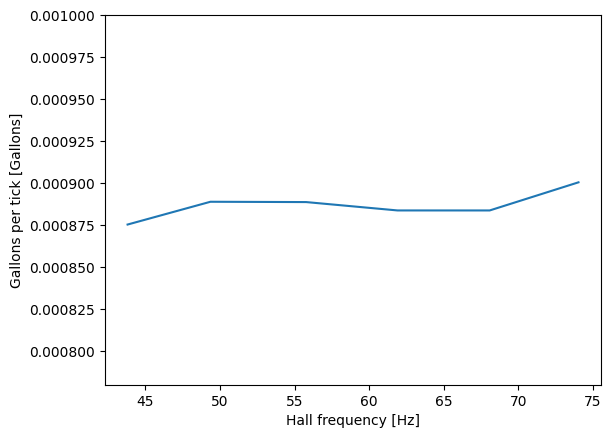

In [ ]:
plt.plot(frequency_list, hall_gpt_list)
plt.ylim([0.00078,0.001])
plt.xlabel('Hall frequency [Hz]')
plt.ylabel('Gallons per tick [Gallons]')
plt.show()